In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [79]:
df=pd.read_json('/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json',lines=True)

In [80]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [81]:
df.shape

(209527, 6)

In [82]:
df.iloc[1,2]

'U.S. NEWS'

In [83]:
df.nunique()

link                 209486
headline             207996
category                 42
short_description    187022
authors               29169
date                   3890
dtype: int64

In [84]:
df.drop_duplicates(inplace=True)

In [85]:
df.shape

(209514, 6)

In [86]:
import pandas_profiling as pp
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [87]:
df.drop(['link','authors','date'],axis=1,inplace=True)

In [88]:
df.columns

Index(['headline', 'category', 'short_description'], dtype='object')

In [89]:
(df['category'].value_counts()/df.shape[0])*100

POLITICS          16.992182
WELLNESS           8.563628
ENTERTAINMENT      8.286797
TRAVEL             4.725221
STYLE & BEAUTY     4.682742
PARENTING          4.195901
HEALTHY LIVING     3.195013
QUEER VOICES       3.029392
FOOD & DRINK       3.026051
BUSINESS           2.859952
COMEDY             2.577393
SPORTS             2.423227
BLACK VOICES       2.187443
HOME & LIVING      2.061915
PARENTS            1.887702
THE WORLDPOST      1.748809
WEDDINGS           1.743559
WOMEN              1.704421
CRIME              1.700125
IMPACT             1.662896
DIVORCE            1.635213
WORLD NEWS         1.574596
MEDIA              1.405157
WEIRD NEWS         1.325448
GREEN              1.251468
WORLDPOST          1.230944
RELIGION           1.229989
STYLE              1.075823
SCIENCE            1.052913
TECH               1.002320
TASTE              1.000410
MONEY              0.838130
ARTS               0.720238
ENVIRONMENT        0.688737
FIFTY              0.668690
GOOD NEWS          0

In [119]:
df['des_len']=df['short_description'].apply(lambda X:len(X))
df['head_len']=df['headline'].apply(lambda X:len(X))

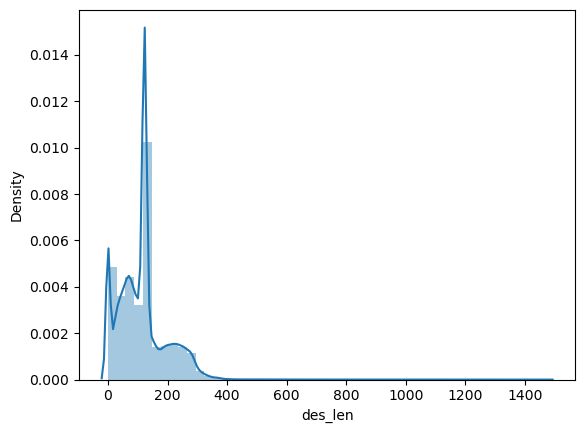

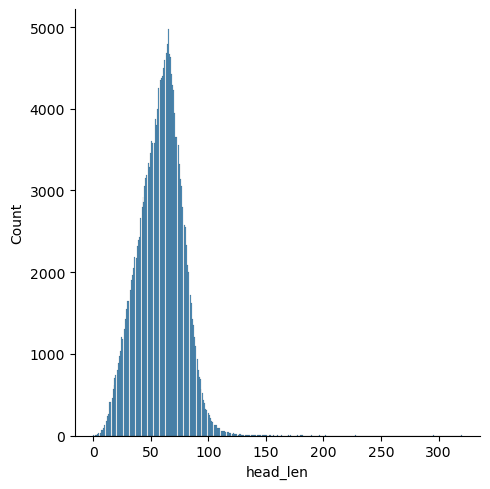

In [120]:
sns.distplot(df['des_len'])
sns.displot(df['head_len'])


In [90]:
max(df['headline'].str.len())

320

In [91]:
max(df['short_description'].str.len())

1472

In [92]:
df.groupby(['category'])

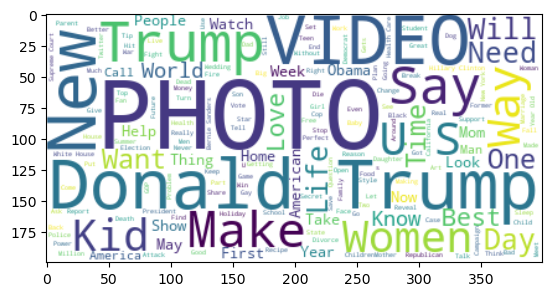

In [93]:
text = " ".join(i for i in df.headline)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')

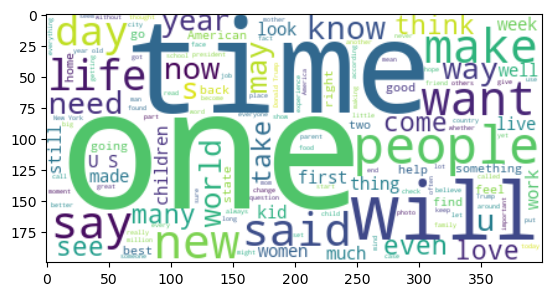

In [94]:
text = " ".join(i for i in df.short_description)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')

In [95]:
import nltk
from nltk.corpus import stopwords
vectorizer=CountVectorizer()
nltk.download('stopwords')
stop=stopwords.words('english')
pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
stemmer=RSLPStemmer()  
def text_processing(sentences):
    processed=[]
    for sen in sentences:
        sen=str(sen)
        sen=re.sub('[\n\r]',' ',sen)
        sen=re.sub(pattern,'link',sen)
        sen=re.sub('\W', ' ', sen)
        sen=re.sub('\s+', ' ', sen)
        sen=re.sub('[ \t]+$', '', sen)
        sen=" ".join([word.lower() for word in sen.split() if word.lower() not in stop])
        sen=' '.join([stemmer.stem(word) for word in sen.split()])
        processed.append(sen)
    return processed

des = text_processing(df['short_description'].tolist())
headline=text_processing(df['headline'].tolist())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
from sklearn.metrics.pairwise import cosine_similarity
df['short_des']=des
df['head']=headline
def similar(news,data,colname=None):
    vectorizer = TfidfVectorizer(stop_words = "english")
    vectors = vectorizer.fit_transform(data[colname])
    news= [news]
    news_vector = vectorizer.transform(news)
    sim = cosine_similarity(X = vectors, Y = news_vector)
    return sim


    

In [108]:
#similarity using short description column
df.iloc[1,:]

headline             American Airlines Flyer Charged, Banned For Li...
category                                                     U.S. NEWS
short_description    He was subdued by passengers and crew when he ...
short_des            subdued passeng crew fled back aircraft confro...
head                 american airlin fly charged banned lif punchin...
Name: 1, dtype: object

In [110]:
s=similar(df.iloc[1,2],df,'short_des')
for i in np.argsort(s,axis = 0)[::-1][:5]:
    print(df['short_des'].tolist()[i[0]])
    print('____________________________')

subdued passeng crew fled back aircraft confrontation according u attorney offic lo angel
____________________________
man already subdued offic fired called piec
____________________________
polic say fled around 2 000
____________________________
flight crew keep cabin do open aircraft boarded specific reason wait
____________________________
los
____________________________


In [103]:
df.iloc[2,:]

headline             23 Of The Funniest Tweets About Cats And Dogs ...
category                                                        COMEDY
short_description    "Until you have a dog you don't understand wha...
short_des                                   dog understand could eaten
head                         23 funniest tweet cat dog week sept 17 23
Name: 2, dtype: object

In [111]:
s=similar(df.iloc[1,0],df,'head')
for i in np.argsort(s,axis = 0)[::-1][:5]:
    print(df['short_des'].tolist()[i[0]])
    print('____________________________')

subdued passeng crew fled back aircraft confrontation according u attorney offic lo angel
____________________________
flight attendant may sleep secret hideaway long flight usually stay hotel mult day trip
____________________________
best way annoy flight attendant best way get flight attendant good sid sat flight attendant maj passeng airlin learn lik part cabin crew
____________________________
tak headphon
____________________________
according report dall morning new flight attendant cam pa syst ranting aa bankruptcy
____________________________
